In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [6]:
def load_data(file_path):
    df = pd.read_csv(file_path)
    # Convert datum to datetime
    df['datum'] = pd.to_datetime(df['datum'])
    return df
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    
    for i in range(len(data) - sequence_length):
        sequence = data[i:(i + sequence_length)]
        target = data[i + sequence_length]
        sequences.append(sequence)
        targets.append(target)
    
    return np.array(sequences), np.array(targets)

In [7]:
df.isnull().sum()

datum           0
M01AB           0
M01AE           0
N02BA           0
N02BE           0
N05B            0
N05C            0
R03             0
R06             0
Year            0
Month           0
Hour            0
Weekday Name    0
dtype: int64

In [8]:
medicine_columns = ['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06']

def prepare_data(df, sequence_length=7):
    # Select medicine columns
    data = df[medicine_columns].values
    
    # Scale the data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    
    # Create sequences
    X, y = create_sequences(scaled_data, sequence_length)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    return X_train, X_test, y_train, y_test, scaler

In [9]:
def create_model(sequence_length, n_features):
    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, 
            input_shape=(sequence_length, n_features)),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(n_features)
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae','mse'])
    return model

In [10]:
def train_model(model, X_train, y_train, X_test, y_test):
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_test, y_test),
        verbose=1
    )
    return history


In [11]:
def make_predictions(model, X_test, scaler):
    predictions = model.predict(X_test)
    
    # Inverse transform predictions
    predictions = scaler.inverse_transform(predictions)
    actual = scaler.inverse_transform(y_test)
    
    return predictions, actual

In [12]:
def plot_results(history, predictions, actual, medicine_columns):
    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Plot predictions vs actual for each medicine
    plt.figure(figsize=(15, 10))
    for i, medicine in enumerate(medicine_columns):
        plt.subplot(4, 2, i+1)
        plt.plot(actual[:, i], label='Actual')
        plt.plot(predictions[:, i], label='Predicted')
        plt.title(f'{medicine} Stock Prediction')
        plt.legend()
    plt.tight_layout()
    plt.show()

Epoch 1/50


d:\Users\conne\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0388 - mae: 0.1464 - mse: 0.0388 - val_loss: 0.0196 - val_mae: 0.1048 - val_mse: 0.0195
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0194 - mae: 0.1045 - mse: 0.0194 - val_loss: 0.0195 - val_mae: 0.1017 - val_mse: 0.0192
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0186 - mae: 0.1018 - mse: 0.0186 - val_loss: 0.0184 - val_mae: 0.1011 - val_mse: 0.0180
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0185 - mae: 0.1019 - mse: 0.0185 - val_loss: 0.0184 - val_mae: 0.1000 - val_mse: 0.0181
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0184 - mae: 0.1011 - mse: 0.0184 - val_loss: 0.0186 - val_mae: 0.0998 - val_mse: 0.0184
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0179 - mae: 0.1000 - mse: 0.0179 - val_loss: 0.0184 - val_mae: 0.0992 - val_mse: 0.0182
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0175 - mae: 0.0992 - mse: 0.0175 - val_loss: 0.0182 - val_mae:

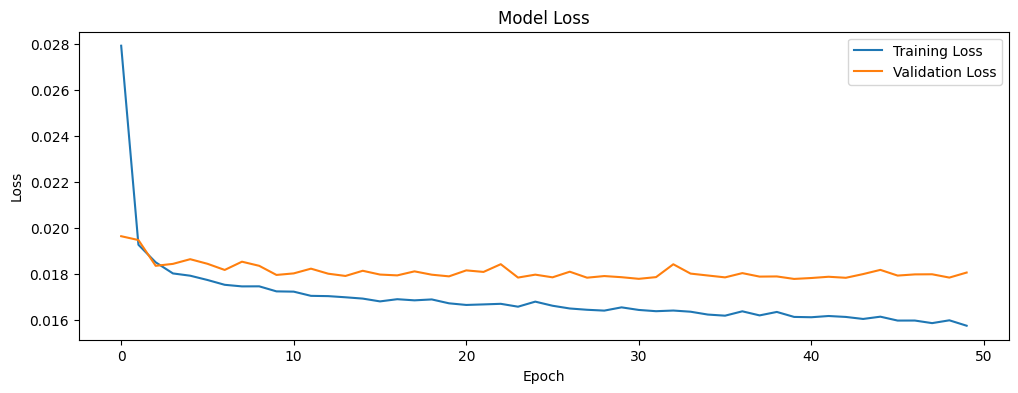

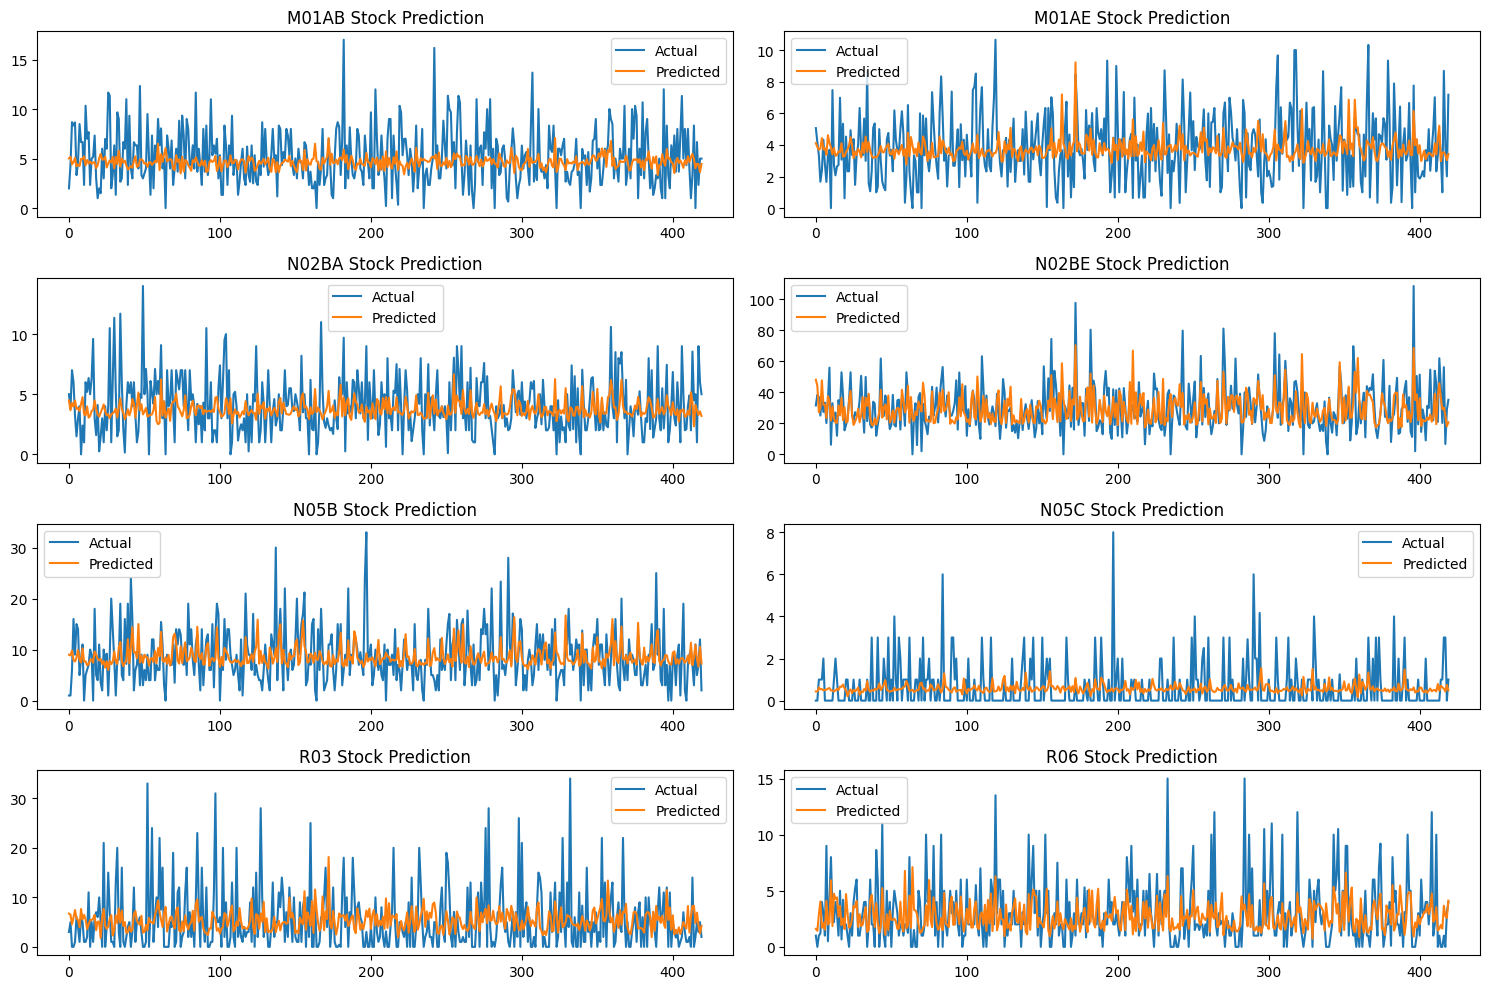

In [14]:
# Load and prepare data
df = load_data('salesdaily.csv')
sequence_length = 7
X_train, X_test, y_train, y_test, scaler = prepare_data(df, sequence_length)

# Create and train model
model = create_model(sequence_length, len(medicine_columns))
history = train_model(model, X_train, y_train, X_test, y_test)

# Make predictions
predictions, actual = make_predictions(model, X_test, scaler)

# Plot results
plot_results(history, predictions, actual, medicine_columns)

# Make future predictions
def predict_future_stock(model, last_sequence, scaler, n_future=30):
    future_predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(n_future):
        # Get prediction for next time step
        pred = model.predict(current_sequence.reshape(1, sequence_length, -1))
        future_predictions.append(pred[0])
        
        # Update sequence for next prediction
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1] = pred[0]
    
    future_predictions = np.array(future_predictions)
    future_predictions = scaler.inverse_transform(future_predictions)
    
    return future_predictions

In [ ]:
def predict_next_day(last_n_days, model, scaler):
    """
    Predict next day's values based on the last n days
    
    Parameters:
    last_n_days: DataFrame containing the last n days of data
    model: trained LSTM model
    scaler: fitted MinMaxScaler
    
    Returns:
    Dictionary with predictions for each medicine
    """

    scaled_input = scaler.transform(last_n_days[medicine_columns])
    

    model_input = scaled_input.reshape(1, sequence_length, len(medicine_columns))
    

    prediction = model.predict(model_input)
    
    # Inverse transform prediction
    prediction_unscaled = scaler.inverse_transform(prediction)
    
    # Create dictionary of predictions
    prediction_dict = {
        medicine: prediction_unscaled[0][i] 
        for i, medicine in enumerate(medicine_columns)
    }
    
    return prediction_dict

# 7. Function for multiple day prediction
def predict_next_n_days(last_n_days, model, scaler, n_days=7):
    """
    Predict values for the next n days
    
    Parameters:
    last_n_days: DataFrame containing the last n days of data
    model: trained LSTM model
    scaler: fitted MinMaxScaler
    n_days: number of days to predict ahead
    
    Returns:
    List of dictionaries with predictions for each day
    """
    predictions = []
    current_data = last_n_days[medicine_columns].copy()
    
    for _ in range(n_days):
        # Get prediction for next day
        pred_dict = predict_next_day(current_data, model, scaler)
        predictions.append(pred_dict)
        
        # Update data for next prediction
        new_row = pd.DataFrame([pred_dict])
        current_data = pd.concat([current_data[1:], new_row]).reset_index(drop=True)
    
    return predictions

# 8. USAGE EXAMPLE:
# To predict next day:
last_days = df.tail(sequence_length)  # Get last 3 days
next_day_prediction = predict_next_day(last_days, model, scaler)

print("\nPredicted values for next day:")
for medicine, value in next_day_prediction.items():
    print(f"{medicine}: {value:.2f}")

# To predict next 7 days:
next_week_predictions = predict_next_n_days(last_days, model, scaler, n_days=7)

print("\nPredicted values for next 7 days:")
for day, pred in enumerate(next_week_predictions, 1):
    print(f"\nDay {day}:")
    for medicine, value in pred.items():
        print(f"{medicine}: {value:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

Predicted values for next day:
M01AB: 4.40
M01AE: 3.66
N02BA: 3.62
N02BE: 29.97
N05B: 8.97
N05C: 0.50
R03: 4.96
R06: 1.81
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

d:\Users\conne\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
d:\Users\conne\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
d:\Users\conne\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
d:\Users\conne\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Predicted values for next 7 days:

Day 1:
M01AB: 4.40
M01AE: 3.66
N02BA: 3.62
N02BE: 29.97
N05B: 8.97
N05C: 0.50
R03: 4.96
R06: 1.81

Day 2:
M01AB: 4.40
M01AE: 3.69
N02BA: 3.68
N02BE: 30.76
N05B: 8.95
N05C: 0.49
R03: 5.22
R06: 1.81

Day 3:
M01AB: 4.45
M01AE: 3.76
N02BA: 3.63
N02BE: 30.51
N05B: 8.63
N05C: 0.49
R03: 5.40
R06: 1.78

Day 4:
M01AB: 4.43
M01AE: 3.86
N02BA: 3.88
N02BE: 32.05
N05B: 8.63
N05C: 0.52
R03: 5.92
R06: 1.86

Day 5:
M01AB: 5.19
M01AE: 4.97
N02BA: 4.55
N02BE: 41.26
N05B: 8.32
N05C: 0.44
R03: 7.32
R06: 2.58

Day 6:
M01AB: 5.15
M01AE: 4.71
N02BA: 4.09
N02BE: 42.31
N05B: 8.85
N05C: 0.43
R03: 7.77
R06: 1.72

Day 7:
M01AB: 4.21
M01AE: 3.76
N02BA: 3.94
N02BE: 31.36
N05B: 9.66
N05C: 0.62
R03: 5.84
R06: 1.64


d:\Users\conne\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
d:\Users\conne\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
d:\Users\conne\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
d:\Users\conne\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
